In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

## Convert MNIST to Torch Tensors

In [3]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [4]:
transform = transforms.ToTensor()  
# There are many other transforms, for this one, we only use ToTensor

In [5]:
train_data = datasets.MNIST(root='../PYTORCH_NOTEBOOKS/Data',
                            train=True,
                            download=True,
                            transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../PYTORCH_NOTEBOOKS/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [6]:
test_data = datasets.MNIST(root='../PYTORCH_NOTEBOOKS/Data',
                           train=False,
                           download=True,
                           transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../PYTORCH_NOTEBOOKS/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


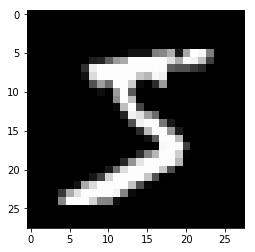

In [8]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

## Data Loader

In [9]:
torch.manual_seed(101)  # for consistent results
train_loader = DataLoader(train_data,
                          batch_size=100,
                          shuffle=True,
                          pin_memory=True)
test_loader = DataLoader(test_data,
                         batch_size=500,
                         shuffle=False,
                         pin_memory=True)

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


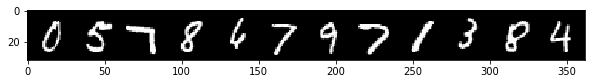

In [10]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the Model

In [11]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        # Wrapper method for ReLU
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)  # Softmax not Sigmoid

<div class="alert alert-info"><strong>NOTE:</strong> You may have noticed our shortcut for adding ReLU to the linear layer. In the last section this was done under the <tt>__init__</tt> section as
<pre style='background-color:rgb(217,237,247)'>
layerlist = []
for i in layers:
    layerlist.append(nn.Linear(n_in,i)) 
    layerlist.append(nn.ReLU(inplace=True))
self.layers = nn.Sequential(*layerlist)</pre>
    
Here we're calling <tt>F.relu()</tt> as a functional wrapper on the linear layer directly:
<pre style='background-color:rgb(217,237,247)'>
def forward(self,X):
    X = F.relu(self.fc1(X))</pre></div>

In [12]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
if use_cuda:
    model = model.cuda()

next(model.parameters()).is_cuda # Need to send model to GPU as well.

True

In [14]:
# Count Parameters (Optional)

In [15]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [16]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    
# EQUIVALENT TO:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print('Batch shape:', images.size())

Batch shape: torch.Size([100, 1, 28, 28])


# Flattening the Images

In [19]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    
# EQUIVALENT TO:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print('Batch shape:', images.size())

Batch shape: torch.Size([100, 1, 28, 28])


In [20]:
images.view(100,-1).size()

torch.Size([100, 784])

## Train the model

In [21]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        if use_cuda:
            X_train, y_train = X_train.cuda(), y_train.cuda()
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{train_loader.batch_size*b:6}/{len(train_data)})]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(train_loader.batch_size*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            if use_cuda:
                X_test, y_test = X_test.cuda(), y_test.cuda()
            
            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000)]  loss: 0.29897100  accuracy:  82.515%
epoch:  0  batch:  400 [ 40000/60000)]  loss: 0.13506080  accuracy:  87.207%
epoch:  0  batch:  600 [ 60000/60000)]  loss: 0.09841238  accuracy:  89.370%
epoch:  1  batch:  200 [ 20000/60000)]  loss: 0.16912812  accuracy:  94.945%
epoch:  1  batch:  400 [ 40000/60000)]  loss: 0.07299543  accuracy:  95.055%
epoch:  1  batch:  600 [ 60000/60000)]  loss: 0.04289687  accuracy:  95.260%
epoch:  2  batch:  200 [ 20000/60000)]  loss: 0.04205293  accuracy:  96.325%
epoch:  2  batch:  400 [ 40000/60000)]  loss: 0.07621273  accuracy:  96.487%
epoch:  2  batch:  600 [ 60000/60000)]  loss: 0.02502985  accuracy:  96.577%
epoch:  3  batch:  200 [ 20000/60000)]  loss: 0.11522066  accuracy:  97.270%
epoch:  3  batch:  400 [ 40000/60000)]  loss: 0.17816688  accuracy:  97.380%
epoch:  3  batch:  600 [ 60000/60000)]  loss: 0.08202674  accuracy:  97.408%
epoch:  4  batch:  200 [ 20000/60000)]  loss: 0.02455118  accuracy:  97.930%

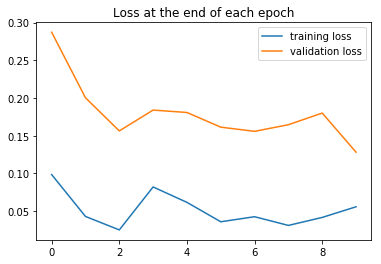

In [22]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

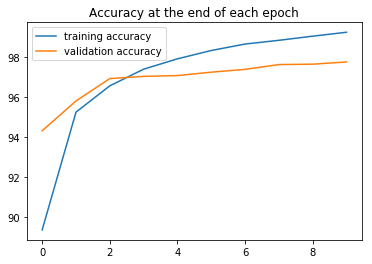

In [23]:
plt.plot([float(t)/len(train_data)*100 for t in train_correct], label='training accuracy')
plt.plot([float(t)/len(test_data)*100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [24]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [25]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        if use_cuda:
            X_test, y_test = X_test.cuda(), y_test.cuda()
        
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9777/10000 =  97.770%


In [26]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu()))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 968    0    2    1    0    2    3    1    3    1]
 [   0 1124    0    1    0    0    3    7    0    2]
 [   3    3 1015    8    3    0    4   10    4    0]
 [   1    1    1  980    1    7    1    2    5    2]
 [   1    0    2    0  960    1    6    1    3    6]
 [   2    0    0   10    0  873    6    1    5    5]
 [   1    2    1    0    4    3  932    0    1    0]
 [   1    1    6    5    0    0    1  996    4    7]
 [   3    4    5    2    0    4    2    3  944    1]
 [   0    0    0    3   14    2    0    7    5  985]]
